# Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from IPython.display import IFrame, display
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score, \
                            classification_report
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Business Problem

Predict whether a customer is likely to cancel their reservation or not, so the business can proactively manage bookings and reduce revenue loss.

In [23]:
# Read data
# the data from https://www.kaggle.com/datasets/ryanholbrook/dl-course-data?select=hotel.csv
hotel = pd.read_csv("hotel.csv")
hotel.shape

(119390, 32)

# Exploratory Data Analysis

In [3]:
# Look at first 5 rows
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# Look at the structure of the dataset
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

We notice that "children" variable should be int type not float, also has 4 missing values.

In [5]:
# Number of duplicated rows
hotel.duplicated().sum()

np.int64(31994)

In [6]:
# For better look at the dataset we will use ydata_profiling
# It's automate the process
# Generate the report
profile = ProfileReport(hotel, title="Hotel Data Report", 
                        samples={"head": 5, "tail": 5},
                        missing_diagrams={"bar": True, "matrix": False, "heatmap": False})

# Save the report to HTML
profile.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.97it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
# Embed the report using iframe
# GitHub does not support rendering iframes 
# or embedded HTML files inside notebooks
# So, I took secreenshot for the important things
IFrame(src = "report.html", width="100%", height="800px")

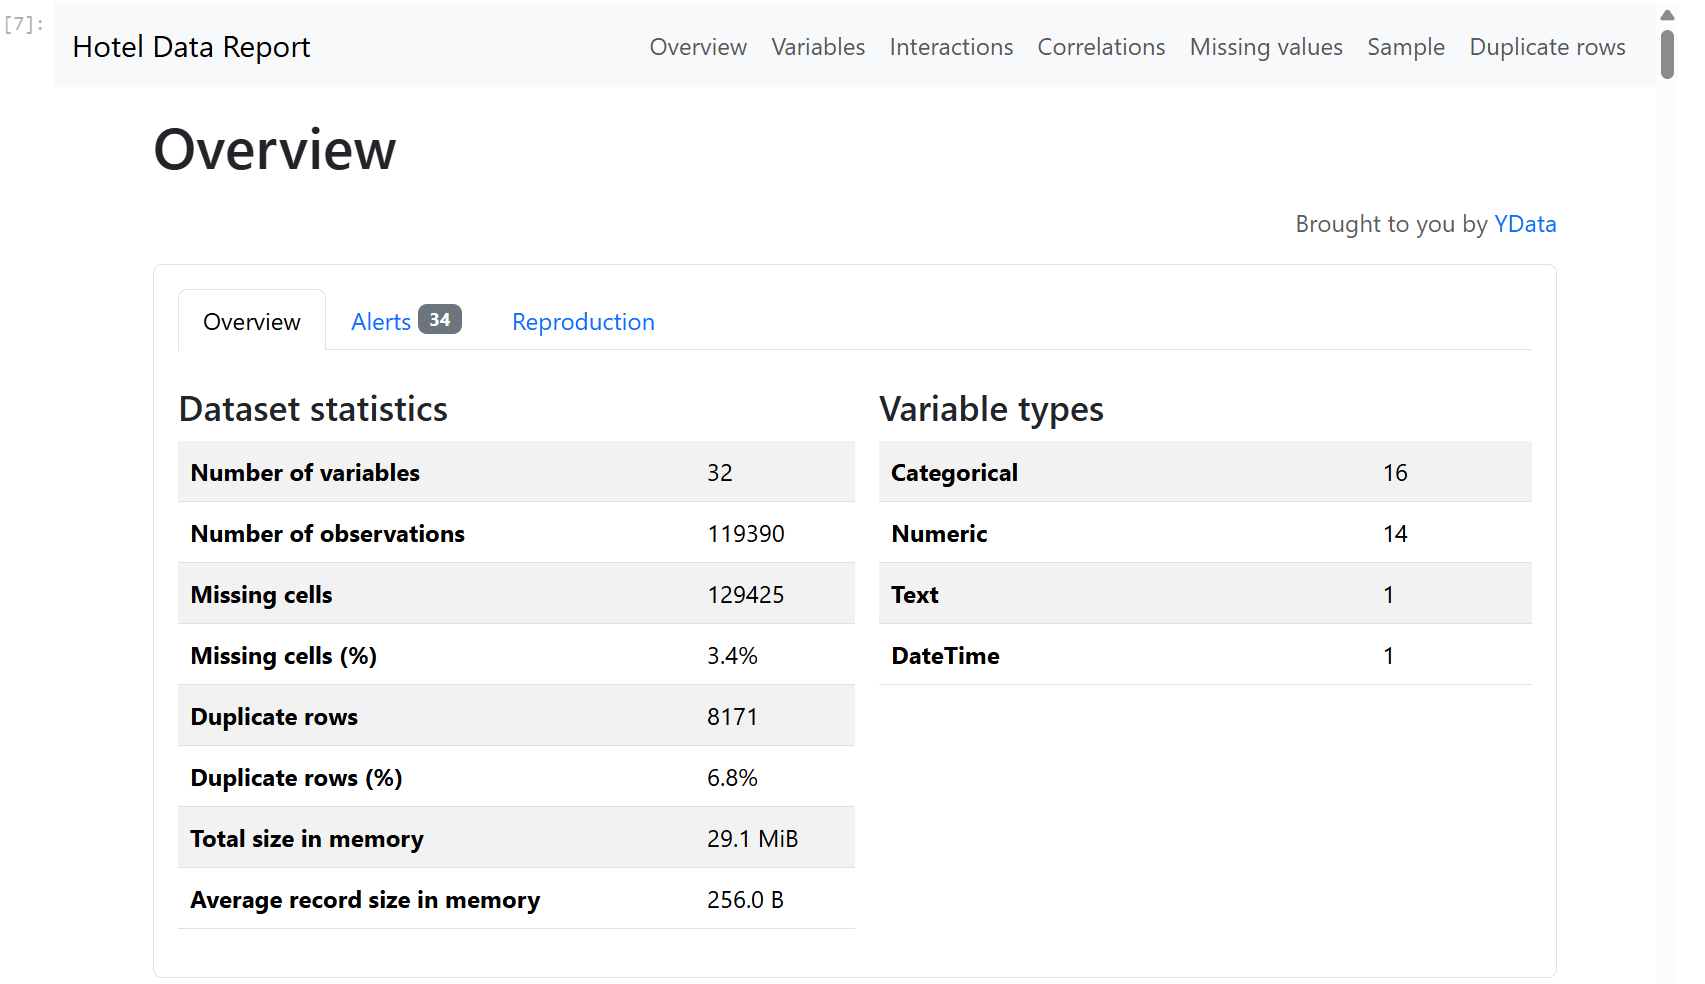

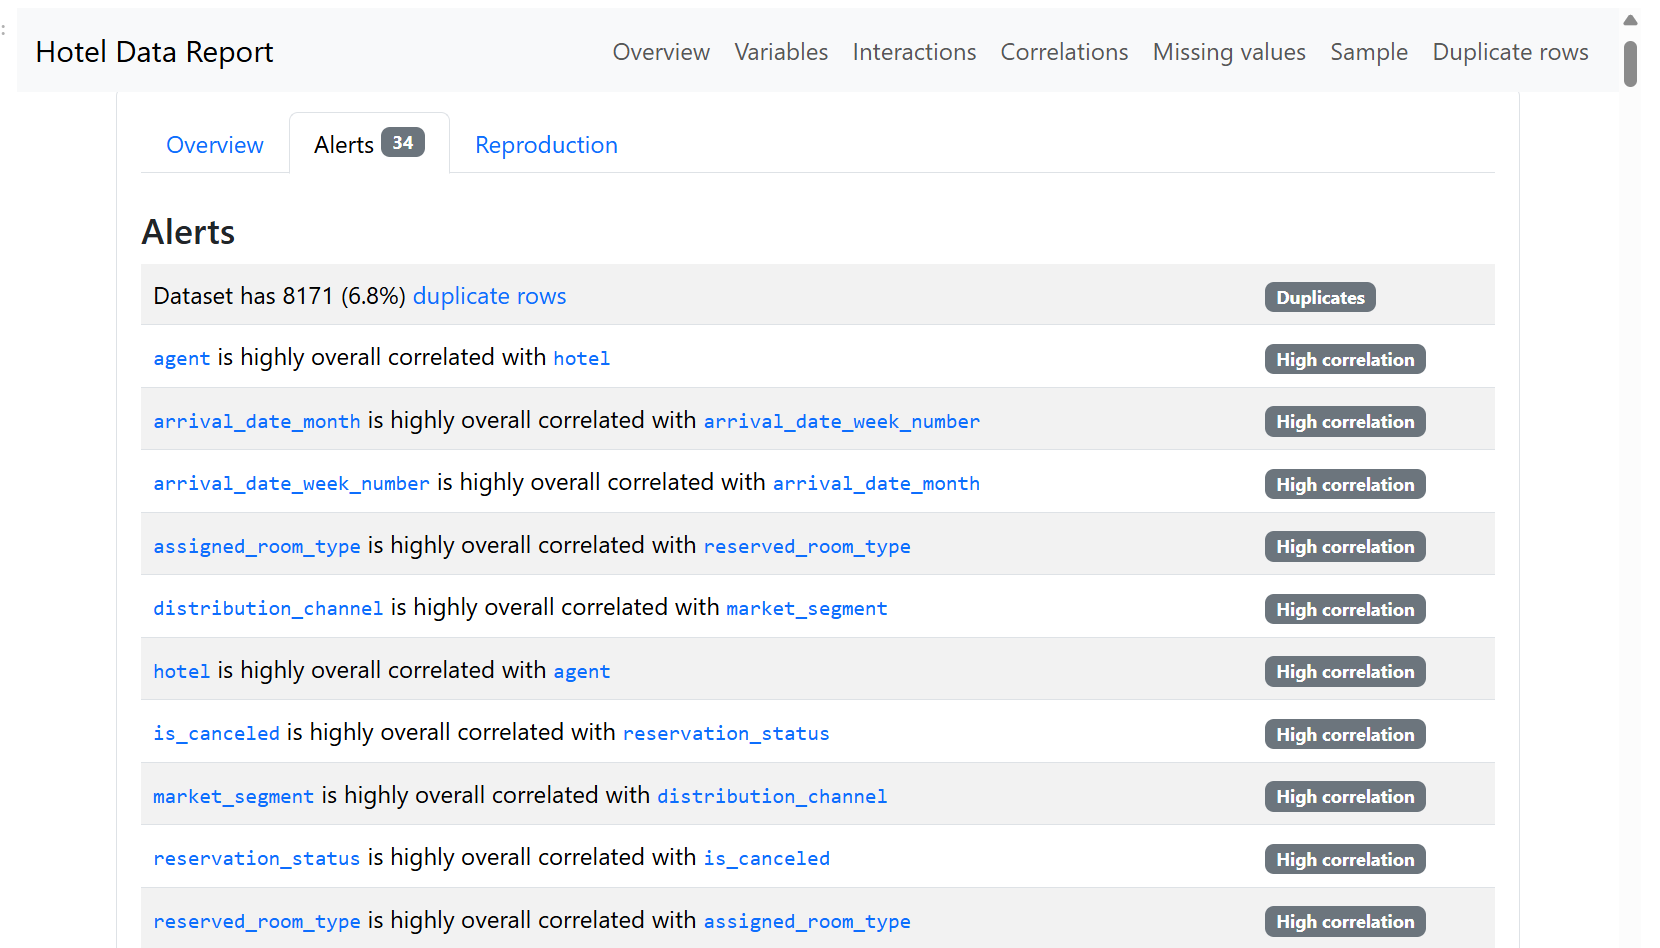
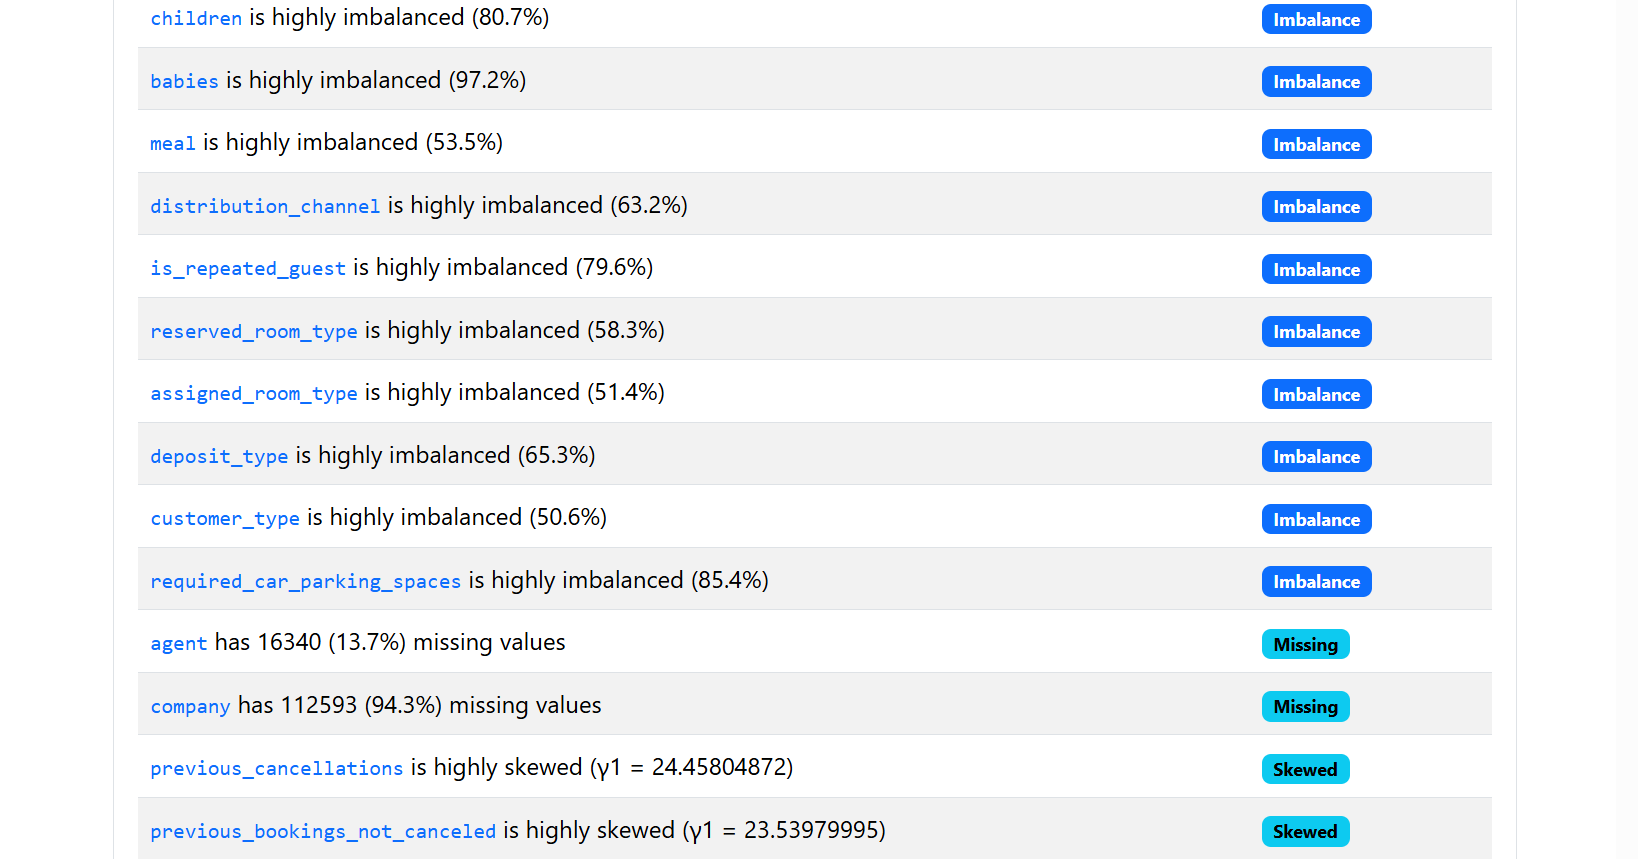

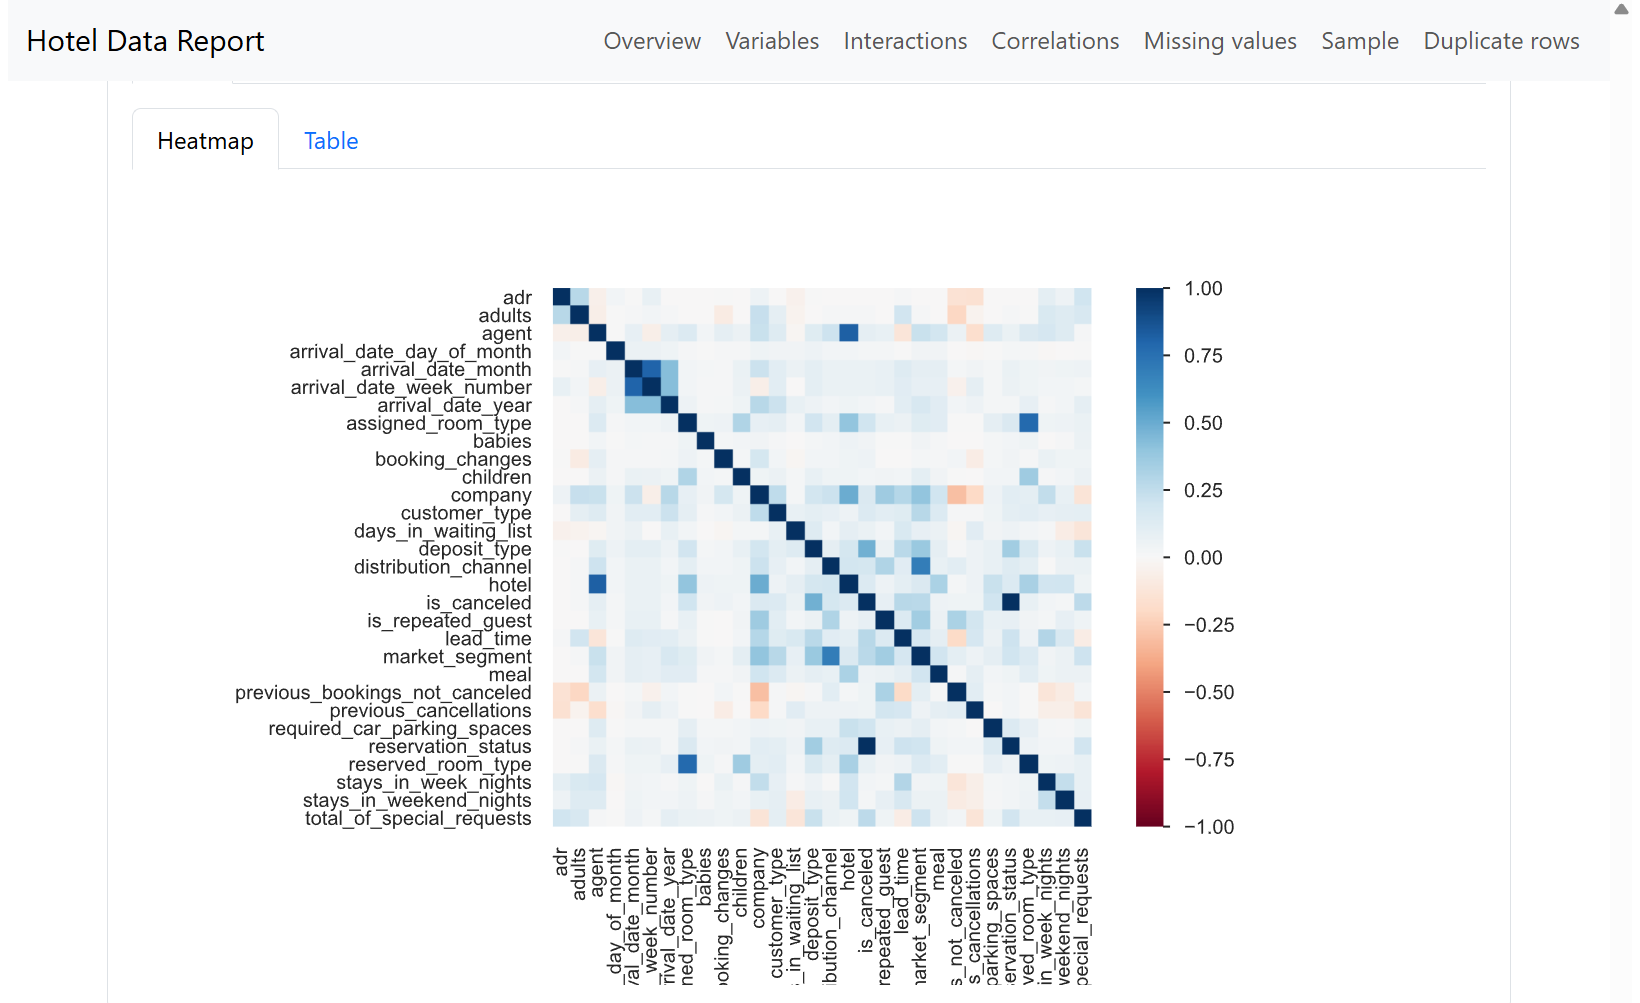

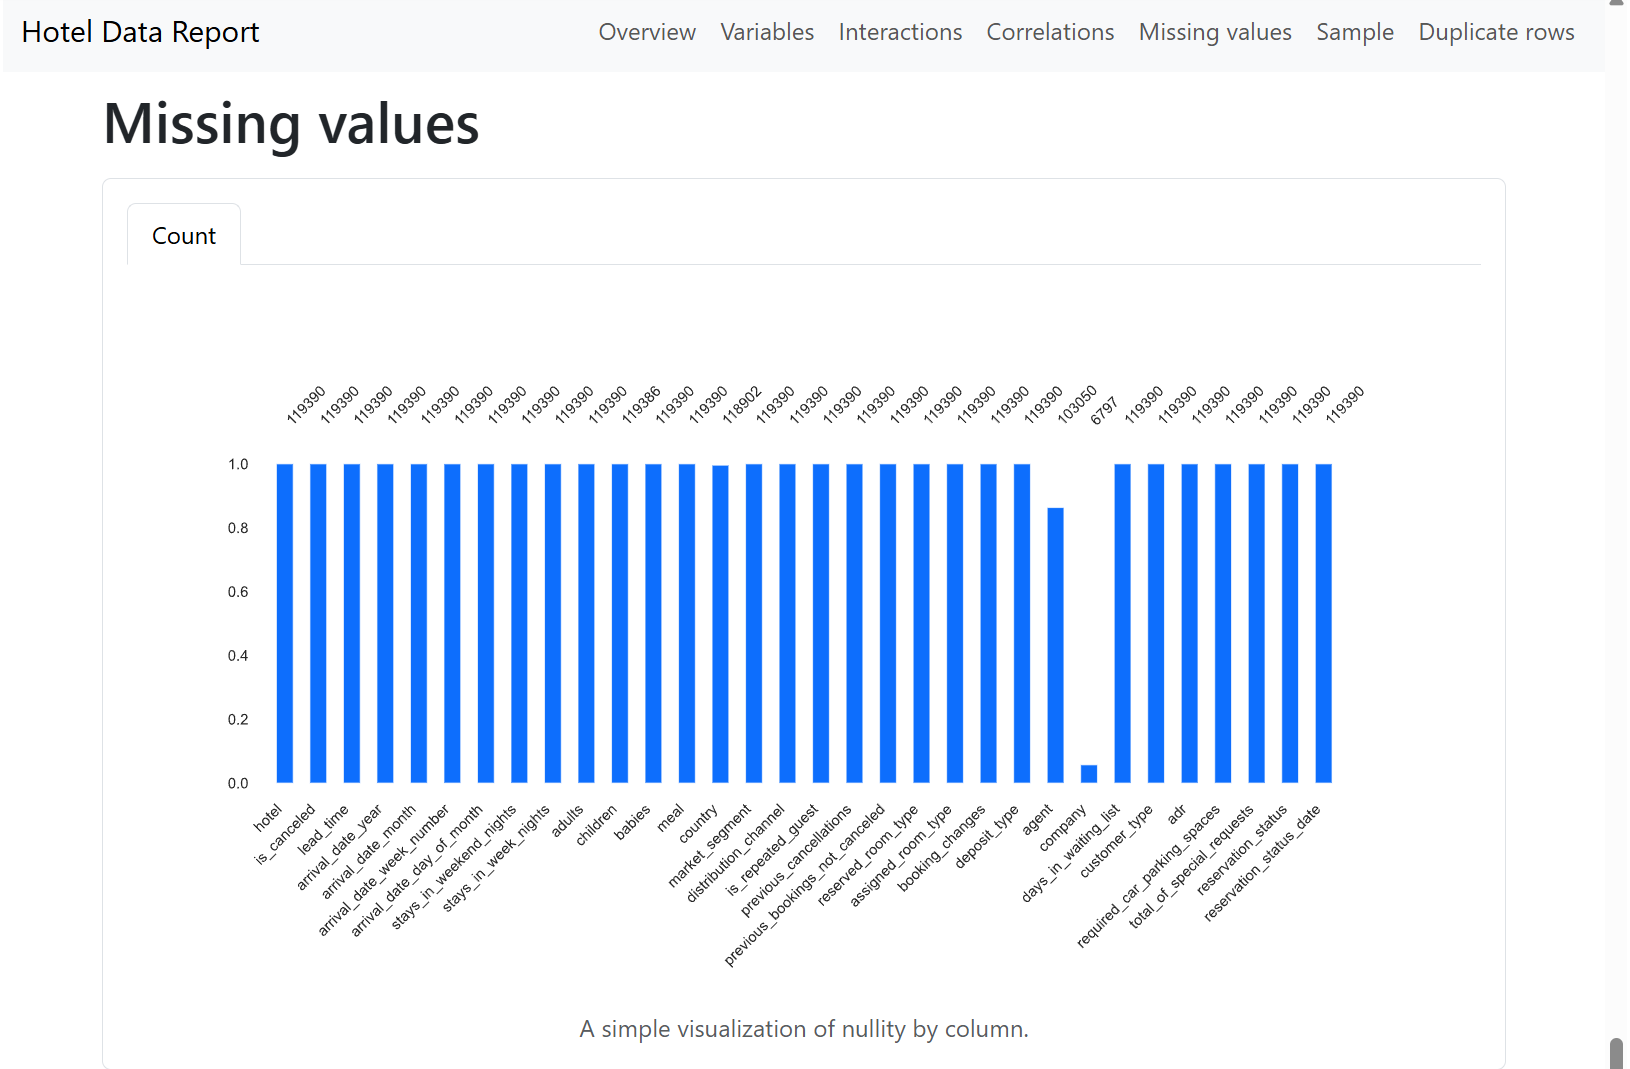

## EDA Conclusion

After carefully examining the dataset through the report, we can say:
- Our target variable is **"is_canceled"** and it's slightly imbalanced. We may need to do oversampling.
- The **Dataset** has 31994 duplicated rows, which we need to delete.
- The **Dataset** has 8171 (6.8%) unique duplicated rows.
- Two variables had missing values: the first is **"company"** with more than 94% missing, which we will delete because it's not useful; the second is **"agent"** with a smaller percentage (13.7%), but since it's highly correlated with "hotel" we will delete it as well.
- Highly correlated features:
1. **"arrival_date_month"** and **"arrival_date_week_number"**, we will keep **"arrival_date_week_number"** since it's already in a suitable format for ML and shows normal distribution.
2. **"assigned_room_type"** and **"reserved_room_type"**, we will keep **"reserved_room_type"** because it has fewer categories (10 < 12).
3. **"distribution_channel"** and **"market_segment"**, we will drop **"market_segment"** because it has more categories (8 > 5).
4. Our target **"is_canceled"** and **"reservation_status"**, we will drop **"reservation_status"** since it contain redundant values for the target variable and may cause data leakage.
- For highly skewed features, we may apply transformations to improve their distribution.
- We will reduce categories in **"country"** and fill missing values with "other", or remove it if it's not important based on the model.
- We will drop **"reservation_status_date"** since it's not useful for the model.

# Preprocessing Data

In [8]:
# Drop duplicate rows
hotel_cleaned = hotel.drop_duplicates()

# Check number of rows
hotel_cleaned.shape

(87396, 32)

In [9]:
# Drop unnecessary cols based on what we conclude through EDA
cols_to_drop = ["company", "agent", "arrival_date_month", 
                "assigned_room_type", "market_segment",
                "reservation_status", "reservation_status_date"]

hotel_cleaned_cols = hotel_cleaned.drop(cols_to_drop, axis=1)

# shape of data
hotel_cleaned_cols.shape

(87396, 25)

In [10]:
# Reduce noise in "country" feature by
# group rare categories to be just 10 countries
top9_countires = hotel_cleaned_cols['country'].value_counts().nlargest(9)
hotel_cleaned_cols['country_grouped'] = hotel_cleaned_cols['country'].apply(lambda x: x if x in top9_countires else "other")

# Drop "country"
hotel_cleaned_data = hotel_cleaned_cols.drop("country", axis=1)

# Countries 
hotel_cleaned_data['country_grouped'].value_counts()

country_grouped
PRT      27453
other    17876
GBR      10433
FRA       8837
ESP       7252
DEU       5387
ITA       3066
IRL       3016
BEL       2081
BRA       1995
Name: count, dtype: int64

In [11]:
# Number of unique categories
hotel_cleaned_data.select_dtypes("object").nunique()

hotel                    2
meal                     5
distribution_channel     5
reserved_room_type      10
deposit_type             3
customer_type            4
country_grouped         10
dtype: int64

Now, if we encode these columns we will get 33 columns plus int and float columns.

In [12]:
# Fill NaN values in "children" column and change the type to int
hotel_cleaned_data['children'] = hotel_cleaned_data['children'].fillna(0)
hotel_cleaned_data['children'] = hotel_cleaned_data['children'].astype(int)

# Check the change
hotel_cleaned_data['children'].dtype

dtype('int64')

In [13]:
# Split features and target
target = hotel_cleaned_data['is_canceled']
features = hotel_cleaned_data.drop('is_canceled', axis=1)

# Split features based on data types
numeric_features = features.select_dtypes(['int64', 'float']).columns.tolist()
categorical_features = features.select_dtypes("object").columns.tolist()

## Scaling & Encoding

We will use pipeline to automate the process

In [14]:
# Define processing pipelines 
# For numerics
numeric_transformer = Pipeline([
    ("scaler", PowerTransformer()),
    ("pca", PCA())
])

# For categorical
categorical_transformer = Pipeline([
    ("encode", OneHotEncoder())
])

In [15]:
# Compine preprocessors
preprocessor = ColumnTransformer([
    ("numeric", numeric_transformer, numeric_features),
    ("categorical", categorical_transformer, categorical_features)
])

# Training & Tuning Models

Automate the process using pipeline

In [16]:
# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.3,
                                                    random_state=10)

In [17]:
# Define multiple models and param grids
models = {
    "logreg": {
        "model": LogisticRegression(random_state=10),
        "params": {
            "preprocessor__numeric__pca__n_components": [None, 2, 5],
            "classifier__max_iter": [150, 300, 500],
            "classifier__C": [0.1, 1, 10]
        }
    },
    "knn": { 
        "model": KNeighborsClassifier(),
        "params": {
            "preprocessor__numeric__pca__n_components": [None, 2, 5],
            "classifier__n_neighbors": [3, 5, 7]
        }
    },
    "decision_tree": {
        "model": DecisionTreeClassifier(random_state=10),
        "params": {
            "preprocessor__numeric__pca__n_components": [None, 2, 5],
            "classifier__max_depth": [None, 5, 10]
        }
    },
    "rf": {
        "model": RandomForestClassifier(random_state=10),
        "params": {
            "preprocessor__numeric__pca__n_components": [None, 2, 5],
            "classifier__n_estimators": [51, 101],
            "classifier__max_depth": [None, 10, 20]
        }
    },
    "xgboost": {
        "model": XGBClassifier(random_state=10),
        "params":{
            "preprocessor__numeric__pca__n_components": [None, 2, 5],
            "classifier__n_estimators": [50, 100],
            "classifier__max_depth": [None, 10, 20]
        }
    }
}

In [18]:
# Build and train models then
# evaluate each model to pick the best one

# Define variables to save best model 
best_model_name = None
best_model_f1 = 0
best_model = None

# Loop through each models
for name, mp in models.items():
    print(f"Training & Tuning: {name}")

    pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", mp['model']),
    ])

    # GridSearch to tuning each model
    gs = GridSearchCV(pipe, mp['params'], cv=3, n_jobs=-1)
    gs.fit(X_train, y_train)

    print(f"Best parameters for {name}: {gs.best_params_}")
    predictions = gs.predict(X_test)

    print(f"Classification Report for {name}")
    print(classification_report(y_test, predictions))
    
    # f1 score for the model
    f1 = f1_score(y_test, predictions)

    # condition to pick best model based on f1 score
    if f1 > best_model_f1:
        best_model_f1 = f1
        best_model_name = name
        best_model = gs

Training & Tuning: logreg
Best parameters for logreg: {'classifier__C': 1, 'classifier__max_iter': 150, 'preprocessor__numeric__pca__n_components': None}
Classification Report for logreg
              precision    recall  f1-score   support

           0       0.82      0.92      0.86     19078
           1       0.67      0.45      0.54      7141

    accuracy                           0.79     26219
   macro avg       0.75      0.69      0.70     26219
weighted avg       0.78      0.79      0.78     26219

Training & Tuning: knn
Best parameters for knn: {'classifier__n_neighbors': 7, 'preprocessor__numeric__pca__n_components': None}
Classification Report for knn
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     19078
           1       0.65      0.56      0.60      7141

    accuracy                           0.80     26219
   macro avg       0.75      0.72      0.73     26219
weighted avg       0.79      0.80      0.79     26219



In [19]:
print("Best Model     : ", best_model_name)
print("Best F1 score  : ", round(f1, 2))
print("Best parameters: ", best_model.best_params_)

Best Model     :  xgboost
Best F1 score  :  0.65
Best parameters:  {'classifier__max_depth': 20, 'classifier__n_estimators': 100, 'preprocessor__numeric__pca__n_components': None}


Based on business problem we depend on F1 score to choose the best model and it seems the model performs better with all features, so there is no need to reduce dimensions.

## Feature Importance Plot for The Best Model

In [20]:
def get_feature_names(preprocessor, numeric_features, categorical_features):
    """To extract features names from the pipeline"""
    output_features = []

    for name, transformer, features in preprocessor.transformers_:
        if name == 'remainder':
            continue  

        if name == 'numeric':
            output_features += features

        elif name == 'categorical':
            ohe = transformer.named_steps['encode'] if isinstance(transformer, Pipeline) else transformer
            cat_ohe_cols = ohe.get_feature_names_out(features)
            output_features += list(cat_ohe_cols)

    return output_features

In [21]:
# Get the best model
clf = best_model.best_estimator_.named_steps["classifier"]

# Transformed feature for eli5
X_transformed = best_model.best_estimator_.named_steps['preprocessor'].transform(X_test)

# Get columns name
column_names = get_feature_names(
    best_model.best_estimator_.named_steps["preprocessor"],
    numeric_features,
    categorical_features
)

In [22]:
# Create, fitting, and generate the plot
perm = PermutationImportance(clf, random_state=10)
perm.fit(X_transformed, y_test)
eli5.show_weights(perm, feature_names = column_names)

Weight,Feature
0.0479 ± 0.0044,country_grouped_PRT
0.0369 ± 0.0033,lead_time
0.0203 ± 0.0012,is_repeated_guest
0.0171 ± 0.0012,babies
0.0148 ± 0.0019,arrival_date_year
0.0146 ± 0.0017,customer_type_Transient
0.0125 ± 0.0008,total_of_special_requests
0.0118 ± 0.0013,arrival_date_day_of_month
0.0115 ± 0.0011,days_in_waiting_list
0.0101 ± 0.0014,distribution_channel_TA/TO


# Summary

- **Formulate Business Problem:** Will the customer likely cancel their reservation?
- **EDA Process:** Examine the dataset to understand it correctly.
- **Preprocessing Data:** Transform the data to make it suitable for ML models.
- **Training & Tuning:** Build a pipeline to automate the entire process and identify the best model based on the F1 score.